# 次元削減とクラスタリング

# 0. 事前準備

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.width', 800)

In [2]:
# データ読み込み
df = pd.read_table('./input/count_tpm.tsv', index_col=0)
print(df.head())
print(len(df))

           batch_1  batch_2  batch_3  chemostat_1  chemostat_2  chemostat_3
gene_id                                                                    
gene_0001     0.00     0.73     3.13         0.00         0.00         0.50
gene_0002     0.00     0.00     0.00         0.00         0.00         0.00
gene_0003     0.00     0.00     0.00         0.00         0.00         0.00
gene_0004     0.00     0.00     0.00         0.00         0.00         0.00
gene_0005     0.95     2.80     4.97         4.69         4.37         8.66
5983


In [3]:
# 全サンプルでTPMがゼロの遺伝子のレコードを削除
all_zero_index = df.index[df.sum(axis=1) == 0]
df = df.drop(all_zero_index)
print(df.head())
print(len(df))

           batch_1  batch_2  batch_3  chemostat_1  chemostat_2  chemostat_3
gene_id                                                                    
gene_0001     0.00     0.73     3.13         0.00         0.00         0.50
gene_0005     0.95     2.80     4.97         4.69         4.37         8.66
gene_0009     1.46     1.24     1.57         3.23         3.78         3.88
gene_0010     8.55     7.96     8.13       159.95       159.68       147.90
gene_0011    17.15    12.23    13.44       147.00       166.23       154.75
5892


In [4]:
# サンプルをプロットするときの色を設定
sample_colors = {'batch_1':'b',  # b : blue
                 'batch_2':'b',
                 'batch_3':'b',
                 'chemostat_1':'g', # g: green
                 'chemostat_2':'g',
                 'chemostat_3':'g'}
colors = df.columns.map(sample_colors)

# 1. 次元削減

## 1. 1 行列分解に基づく次元削減

### 1.1.1 PCA (Principal Component Analysis; 主成分分析)

In [5]:
import sklearn.decomposition

In [6]:
# PCA実行
pca = sklearn.decomposition.PCA()
coords = pca.fit_transform(df.transpose().values)

In [7]:
def scatter_plot(coords, sample_labels, colors, xlabel=None, ylabel=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(coords[:, 0], coords[:, 1], color=colors)
    for i, sample_label in enumerate(sample_labels):
        ax.annotate(sample_label, xy=(coords[i, :2]), xytext=(10,10),
                    textcoords='offset points', color=colors[i],
                   arrowprops={'arrowstyle':'-', 'edgecolor':colors[i]})
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

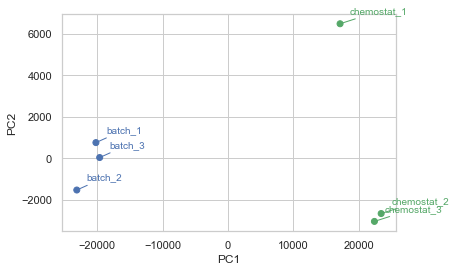

In [8]:
scatter_plot(coords, df.columns, colors, xlabel='PC1', ylabel='PC2')

In [9]:
# z-score 正規化
import sklearn.preprocessing
values = df.transpose().values
scaler = sklearn.preprocessing.StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(values)
std_df = pd.DataFrame(std_values.T, index=df.index, columns=df.columns)

print('\nRaw values')
print('TPM Average :')
print(df.mean(axis=1)[:10])
print('\nTPM Standard deviation :')
print(df.std(ddof=0, axis=1)[:10])

print('\n\nStandardized values')
print('TPM Average :')
print(std_df.mean(axis=1)[:10])
print('\nTPM Standard deviation :')
print(std_df.std(ddof=0, axis=1)[:10])

#おんなじことを自分で計算する場合
#values = df.transpose().values
#std_values = (values - values.mean(axis=0)) / values.std(axis=0)
#std_df2 = pd.DataFrame(std_values.T, index=df.index, columns=df.columns)
#print('\n\nStandardized values 2')
#print('TPM Average :')
#print(std_df2.mean(axis=1)[:10])
#print('\nTPM Standard deviation:')
#print(std_df2.std(ddof=0, axis=1)[:10])


Raw values
TPM Average :
gene_id
gene_0001     0.73
gene_0005     4.41
gene_0009     2.53
gene_0010    82.03
gene_0011    85.13
gene_0012   214.09
gene_0013    80.77
gene_0014    32.10
gene_0015    33.83
gene_0016    27.58
dtype: float64

TPM Standard deviation :
gene_id
gene_0001    1.11
gene_0005    2.35
gene_0009    1.12
gene_0010   73.92
gene_0011   71.10
gene_0012   22.93
gene_0013   13.01
gene_0014    4.40
gene_0015   12.19
gene_0016   12.55
dtype: float64


Standardized values
TPM Average :
gene_id
gene_0001    0.00
gene_0005   -0.00
gene_0009   -0.00
gene_0010   -0.00
gene_0011   -0.00
gene_0012    0.00
gene_0013    0.00
gene_0014   -0.00
gene_0015    0.00
gene_0016   -0.00
dtype: float64

TPM Standard deviation :
gene_id
gene_0001   1.00
gene_0005   1.00
gene_0009   1.00
gene_0010   1.00
gene_0011   1.00
gene_0012   1.00
gene_0013   1.00
gene_0014   1.00
gene_0015   1.00
gene_0016   1.00
dtype: float64


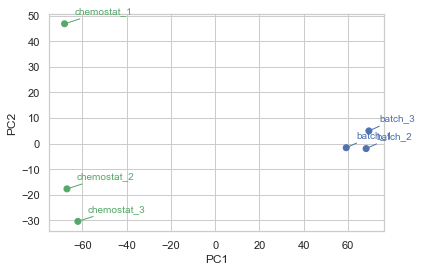

In [10]:
# 標準化されたデータでPCA実行
pca = sklearn.decomposition.PCA()
coords = pca.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors, xlabel='PC1', ylabel='PC2')

In [11]:
# 各主成分の「寄与率」
print(['{:.2f}%'.format(x*100) for x in pca.explained_variance_ratio_])

['73.55%', '9.78%', '7.09%', '5.54%', '4.04%', '0.00%']


### 1.1.2 NMF (Non-negative Matrix Factorization; 非負値行列因子分解)

X ~ W * H


X: non-negative matrix. (n, m)

W: non-negative matrix. (n, k)

H: non-negative matrix. (k, m)

Original


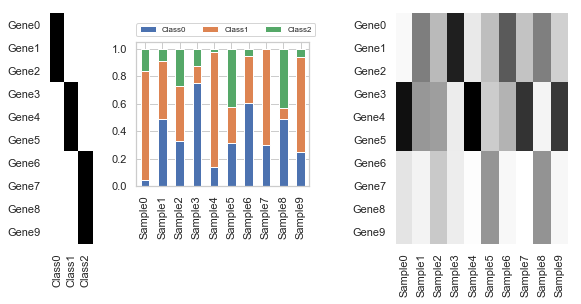

Reconstructed


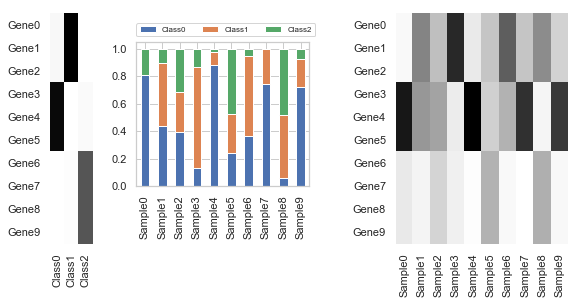

In [12]:
# 擬似データでNMFのデモ

def plot_W_H_X(W, H, X):
    classes = ['Class%d'%x for x in range(W.shape[1])]
    genes = ['Gene%d'%x for x in range(W.shape[0])]
    samples = ['Sample%d'%x for x in range(H.shape[1])]
    fig = plt.figure()
    ax1 = plt.axes([0.0, 0.1, 0.1, 0.8])
    sns.heatmap(pd.DataFrame(W, index=genes, columns=classes), cmap='Greys', cbar=False, ax=ax1)
    ax2 = plt.axes([0.2, 0.3, 0.4, 0.5])
    pd.DataFrame(H, index=classes, columns=samples).transpose().plot.bar(stacked=True, ax=ax2)
    plt.legend(loc=(0., 1.04), ncol=3, fontsize=8)
    ax3 = plt.axes([0.8, 0.1, 0.4, 0.8])
    sns.heatmap(pd.DataFrame(X, index=genes, columns=samples), cmap='Greys', cbar=False)
    plt.show()

print('Original')
                   # class-0 は最初の3個の遺伝子を発現
genes = np.array([[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                  # class-1 はまんなか3個の遺伝子を発現
                   [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                  # class-2 はうしろ4個の遺伝子を発現
                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]]).T
# 各サンプルがclass-0, class-1, class2をどういう割合で持っているか
samples = np.random.dirichlet(alpha=[1.0]*3, size=10).T
# 遺伝子発現テーブルはその掛け算で決まっている（と仮定する）
original_expression_data = np.dot(genes, samples)
plot_W_H_X(genes, samples, original_expression_data)

print('Reconstructed')
# 遺伝子発現テーブルだけを使って、クラスごとの発現パターンベクトル、サンプルごとのクラス割合を復元する
model = sklearn.decomposition.NMF(n_components=3)
W = model.fit_transform(original_expression_data)
W /= W.sum(axis=0)
H = model.components_
H /= H.sum(axis=0)
X = np.dot(W, H)
plot_W_H_X(W, H, X)

In [13]:
model = sklearn.decomposition.NMF(n_components=2)
W = model.fit_transform(df.values)
H = model.components_

print('Original shape=',df.values.shape)
print('W shape =',W.shape)
print('H shape =',H.shape)

Original shape= (5892, 6)
W shape = (5892, 2)
H shape = (2, 6)


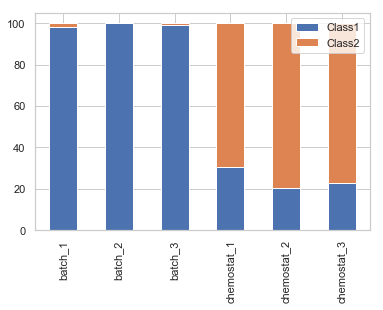

In [14]:
# 次元削減としての利用
H_percentage = 100.0 * H / H.sum(axis=0)
pd.DataFrame(H_percentage.T, index=df.columns, columns=['Class1', 'Class2']).plot.bar(stacked=True)
#各サンプル、もっとも値の高い要素に割り当てることでクラスタリングの代わりとしてしまうこともある。

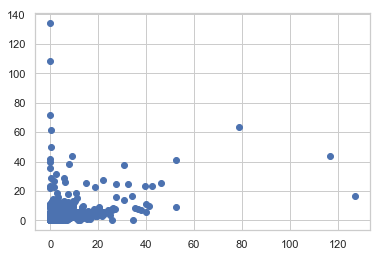

In [15]:
# それぞれの因子に強く寄与している遺伝子はなにか？
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(W[:,0], W[:,1])
plt.show()

In [16]:
# 遺伝子のproduct情報をロード
gene_products = pd.read_table('./input/gene_id_product.tsv', index_col=0, names=["gene_id", "product"])

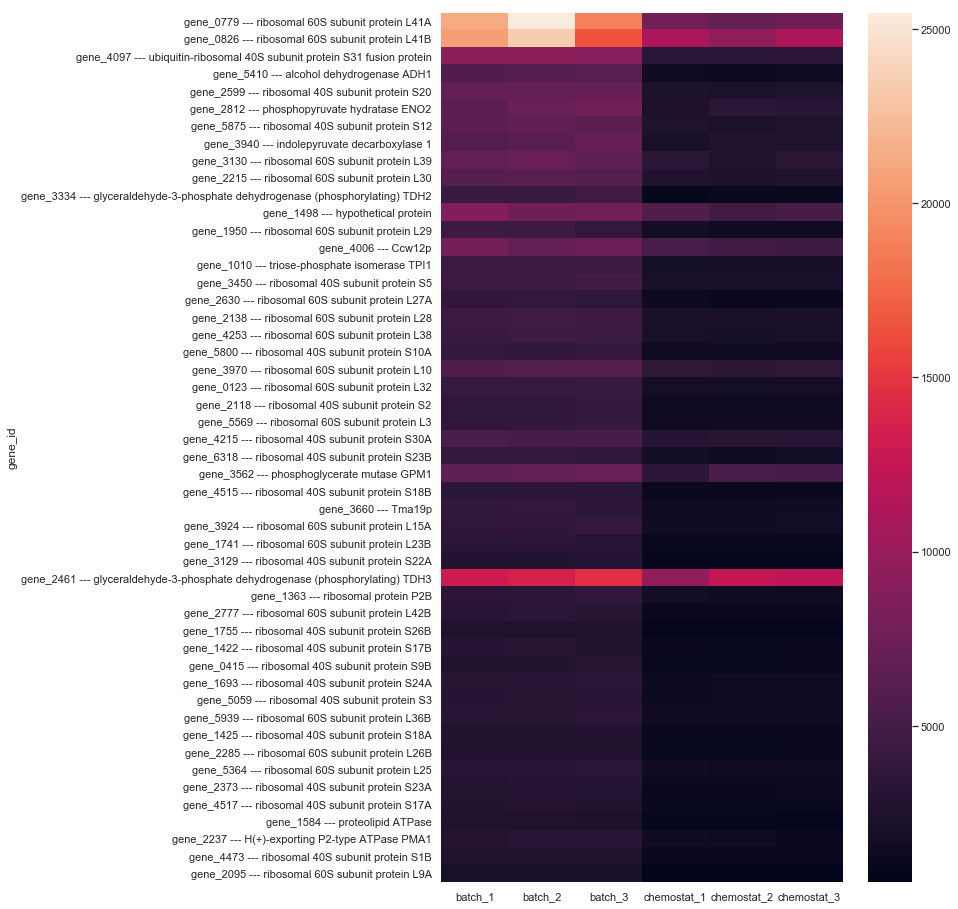

In [17]:
# 因子１　に強く寄与する遺伝子
topN = 50
top_factor1 = df.index[ np.argsort(W[:,0] - W[:,1])[::-1][:topN] ]
gene_labels = top_factor1 + ' --- ' + gene_products.loc[top_factor1, 'product']

fig = plt.figure(figsize=(9,16))
sns.heatmap(df.loc[top_factor1, :], yticklabels=gene_labels)

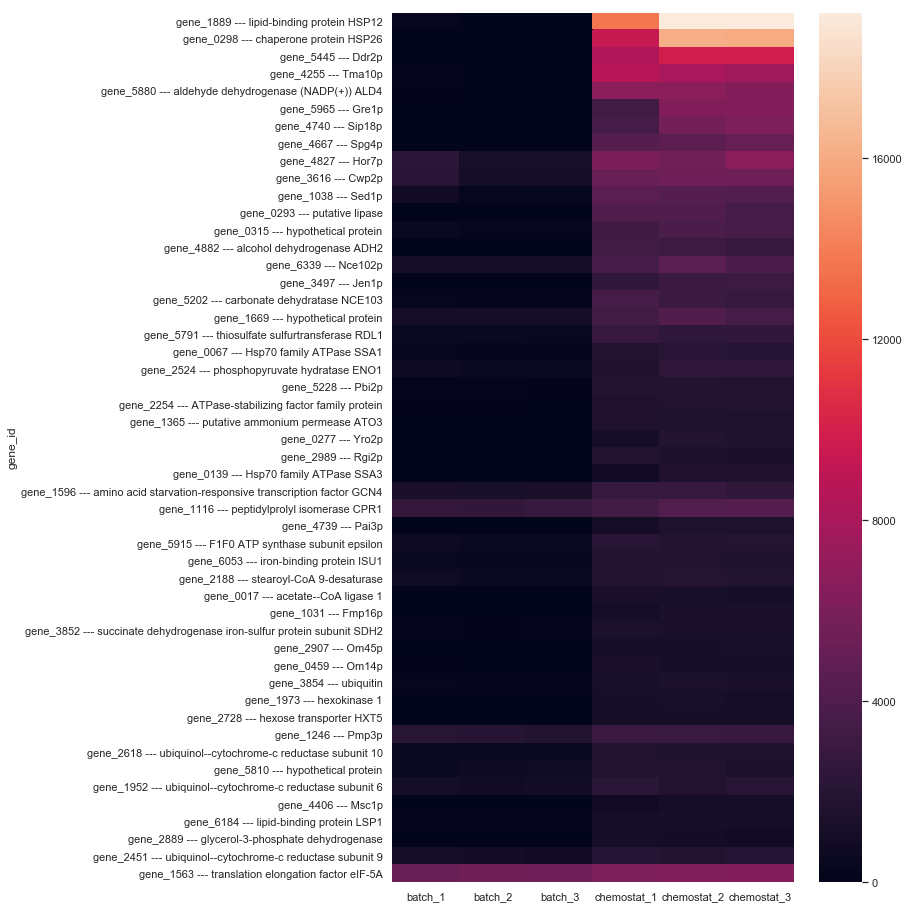

In [18]:
# 因子2　に強く寄与する遺伝子
top_factor2 = df.index[ np.argsort(W[:,0] - W[:,1])[:topN] ]
gene_labels = top_factor2 + ' --- ' + gene_products.loc[top_factor2, 'product']

fig = plt.figure(figsize=(9,16))
sns.heatmap(df.loc[top_factor2, :], yticklabels=gene_labels)

### 1.1.3 LSI (Latent semantic indexing; 潜在意味解析)

In [19]:
# TF-IDF 変換
# TF ... Term Frequency   いくつかの流儀がある。ここではサンプルごとのmaxに対する割合
TF = df.values / df.values.max(axis=0)
# IDF ... Inverse Document Frequency  これもいくつかの流儀あり。
n_samples = len(df.columns)
IDF = np.log2(1.0 + (float(n_samples) / df.values.astype(bool).sum(axis=1)))
# TF-IDF
TFIDF = TF * IDF[:, np.newaxis]
df_tfidf = pd.DataFrame(TFIDF, index=df.index, columns=df.columns)

In [20]:
# SVD (Singular Value Decomposition; 特異値分解)を実行
import numpy.linalg
U, Sig, V = np.linalg.svd(df_tfidf.values, full_matrices=False)
Weights = np.dot(np.diag(Sig), V)

# U, Weights は元の行列を分解したものなので、UとWeightsの掛け算は元の行列を近似
np.allclose(df_tfidf.values, np.dot(U, Weights))

True

In [21]:
U_reduced = U[:, :2]
W_reduced = np.dot(np.diag(Sig[:2]), V[:2, :])

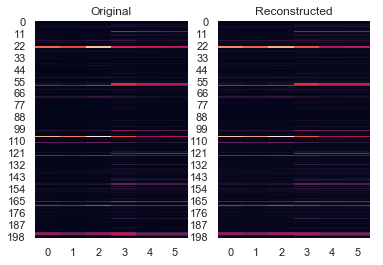

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
sns.heatmap(df_tfidf.values[:200,:], cbar=False, ax=ax1)
ax1.set_title('Original')
ax2 = fig.add_subplot(122)
sns.heatmap(np.dot(U_reduced, W_reduced)[:200,:], cbar=False, ax=ax2)
ax2.set_title('Reconstructed')
plt.show()

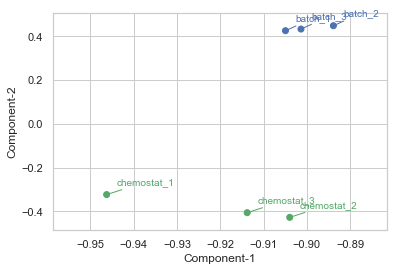

In [25]:
# 長さ１のベクトルにノーマライズする
W_norm = W_reduced / np.sqrt((W_reduced**2).sum(axis=0))
# 2つのcomponentの「重み」空間でサンプルをプロット
scatter_plot(W_norm.T, df_tfidf.columns, colors, xlabel='Component-1', ylabel='Component-2')

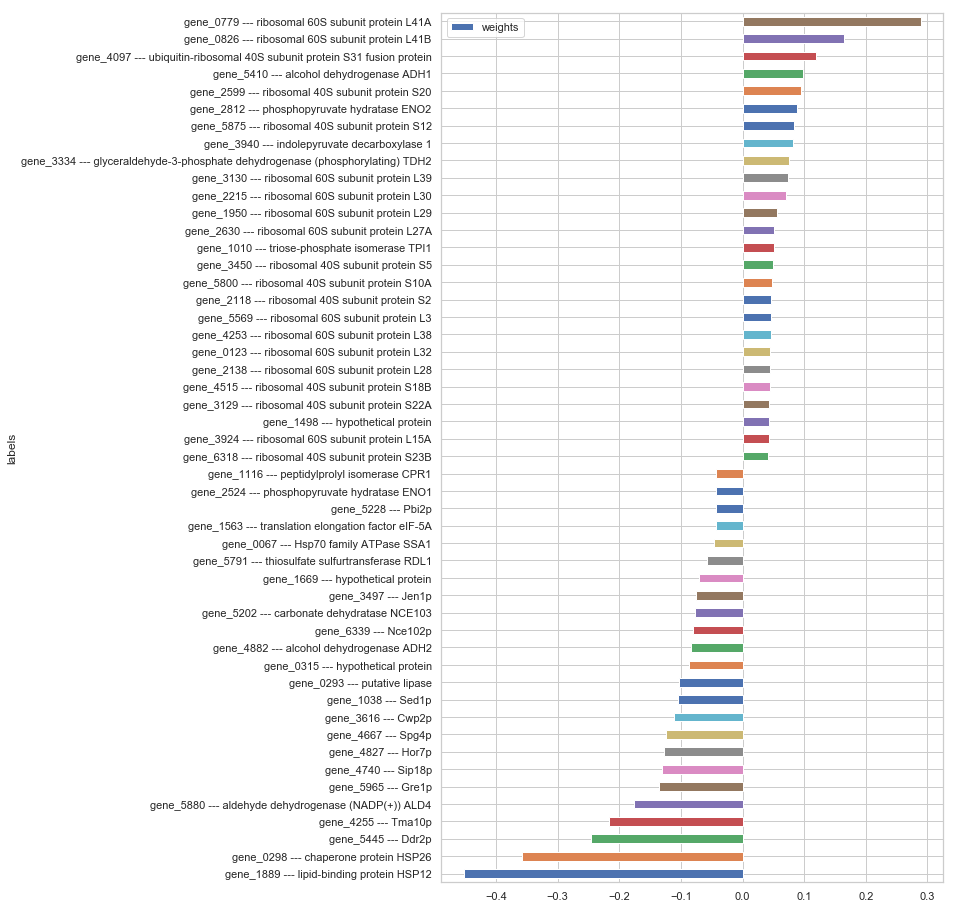

In [26]:
# batch と chemostatの違いは、　Component-2がプラスに寄与するかマイナスに寄与するか。
# Components-2にどういう遺伝子の合成ベクトルなのか、係数が大きい遺伝子をいくつか見てみる
C2_genes = pd.DataFrame(U_reduced[:, 1], index=df_tfidf.index, columns=['weights'])
# 係数の絶対値が大きいトップ50の遺伝子を取得
topN = 50
C2_genes['abs weights'] = np.abs(C2_genes['weights'].values)
C2_genes = C2_genes.sort_values(by=['abs weights'], ascending=False)
C2_genes = C2_genes.head(topN)
C2_genes = C2_genes.sort_values(by=['weights'])
C2_genes['labels'] = C2_genes.index + ' --- ' + gene_products.loc[C2_genes.index, 'product']
C2_genes.plot.barh(y='weights', x='labels', figsize=(9, 16))

## 1. 2 距離行列の最適化に基づく次元削減

### 1.2.1 MDS (Multidimensional scaling; 多次元尺度構成法)

#### metric MDS = PCoA (Principal Coordinate Analysis; 主座標分析)
構成する「距離行列」が、距離関数の要件を満たしている場合に適用可能な手法。

Bray-Curtis dissimilarityなど、三角不等式の要件を満たさない非類似性指標があるので注意。こういう場合はPCoAではなくnMDSを使う。

In [27]:
import sklearn.manifold

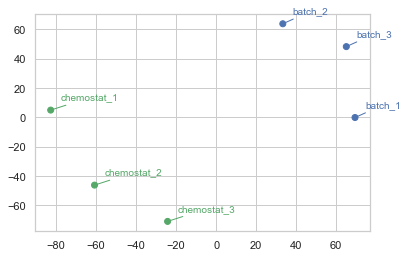

In [28]:
# デフォルトではユークリッド距離でサンプル間距離行列を計算。この場合、数学的には主成分分析と等価。
# ただしscikit-learnのMDS実装はiterativeに最適化するmetric MDSであるため（classical MDS=PCoAは固有値分解に基づく手法）、
# ランダムな初期値の影響で実行のたびに結果が若干変わる
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='euclidean')
coords = mds.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

In [29]:
# 距離行列の計算
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(std_df.transpose().values))
print(distance_matrix)

#自分で距離行列を作る場合（上の一行と同じ計算結果）
#from scipy.spatial.distance import euclidean
#values = std_df.transpose().values
#distance_matrix_2 = []
#for i in range(values.shape[0]):
#    vec = []
#    for j in range(values.shape[0]):
#        vec.append(euclidean(values[i, :], values[j, :]))
#    distance_matrix_2.append(vec)
#print(np.array(distance_matrix_2))

[[  0.          61.3886715   69.82784729 141.72006779 139.27185618
  133.98870325]
 [ 61.3886715    0.          56.11255212 148.032513   143.22201069
  140.71825784]
 [ 69.82784729  56.11255212   0.         149.09664857 146.08961444
  143.53272672]
 [141.72006779 148.032513   149.09664857   0.          76.11398372
   80.8830421 ]
 [139.27185618 143.22201069 146.08961444  76.11398372   0.
   64.40382016]
 [133.98870325 140.71825784 143.53272672  80.8830421   64.40382016
    0.        ]]


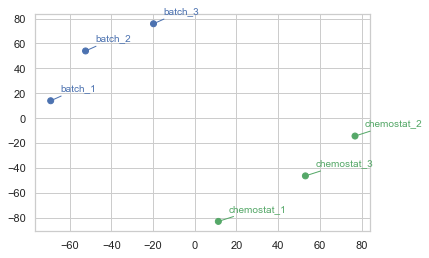

In [30]:
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)

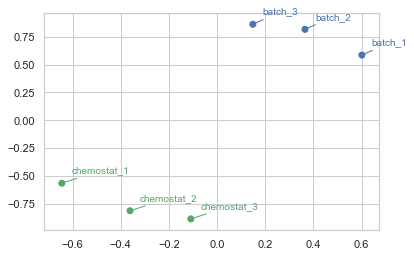

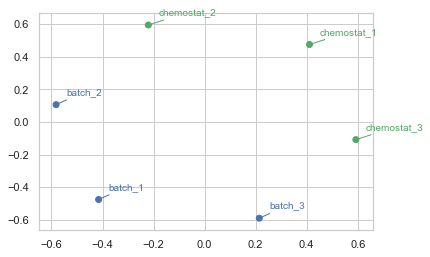

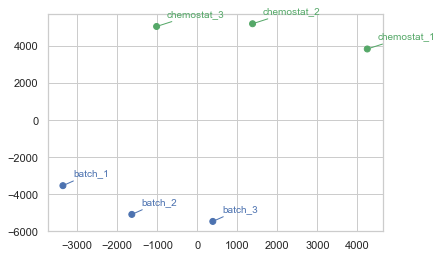

In [31]:
# 相関係数で計算した距離（1 - 相関係数）
distance_matrix = squareform(pdist(std_df.transpose().values, 'correlation'))
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)
# Jaccard距離
distance_matrix = squareform(pdist(std_df.transpose().values, 'jaccard'))
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)
# マンハッタン距離
distance_matrix = squareform(pdist(std_df.transpose().values, 'cityblock'))
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)

#### non-metric MDS (非計量多次元尺度構成法)
構成する「距離行列」が、距離関数の要件を満たさない場合に適用する。

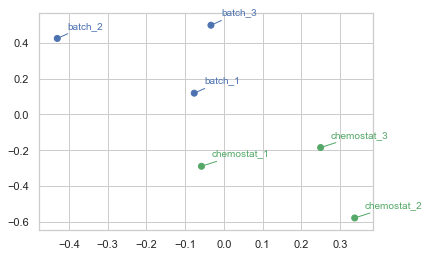

In [32]:
# Bray-Curtis 非類似度指標による計算
distance_matrix = squareform(pdist(std_df.transpose().values, 'braycurtis'))
nmds = sklearn.manifold.MDS(n_components=2, metric=False, dissimilarity='precomputed')
coords = nmds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)

### 1.2.2 多様体学習

#### Isomap

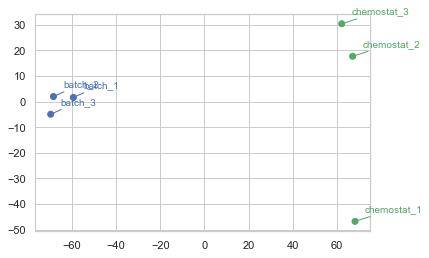

In [33]:
isomap = sklearn.manifold.Isomap(n_components=2)
coords = isomap.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

#### LLE (Locally Linear Embedding)

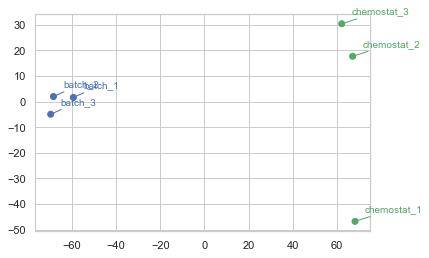

In [34]:
lle = sklearn.manifold.LocallyLinearEmbedding(n_components=2)
coords = isomap.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

#### t-SNE (t-distributed Stochastic Neighbor Embedding)

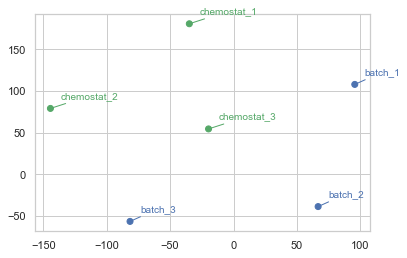

In [35]:
tsne = sklearn.manifold.TSNE(n_components=2)
coords = tsne.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

# 2. クラスタリング

## 2.1 階層的クラスタリング

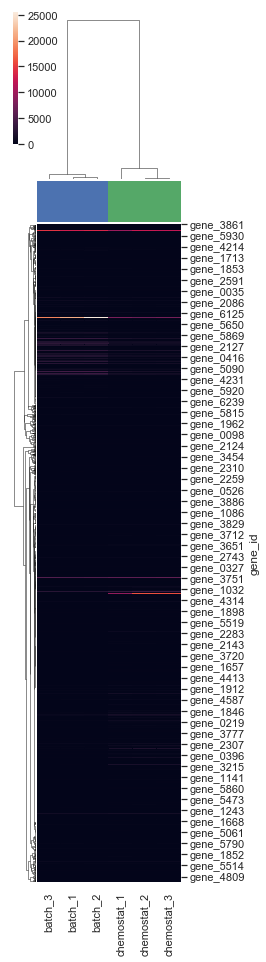

In [36]:
sns.clustermap(df, method='average', metric='correlation', col_colors=colors, figsize=(3, 16))

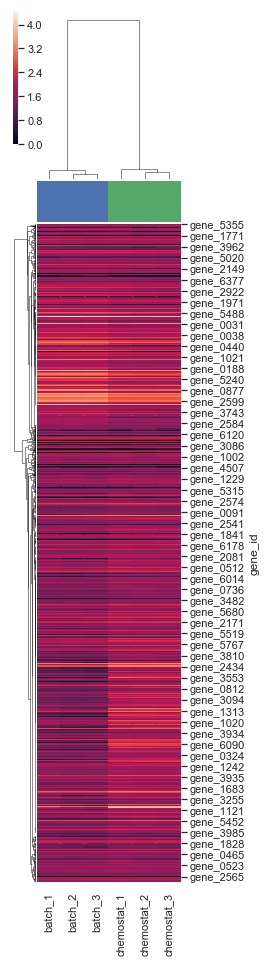

In [37]:
log_transform = lambda x: np.log10(x + 1.0)
sns.clustermap(df.apply(log_transform), method='average', metric='correlation', col_colors=colors, figsize=(3, 16))

In [38]:
# 平均TPMのサンプル間分散がTop-20の遺伝子だけ抜き出し
top20_df = df.loc[df.var(axis=1).sort_values(ascending=False).index[:20], :]

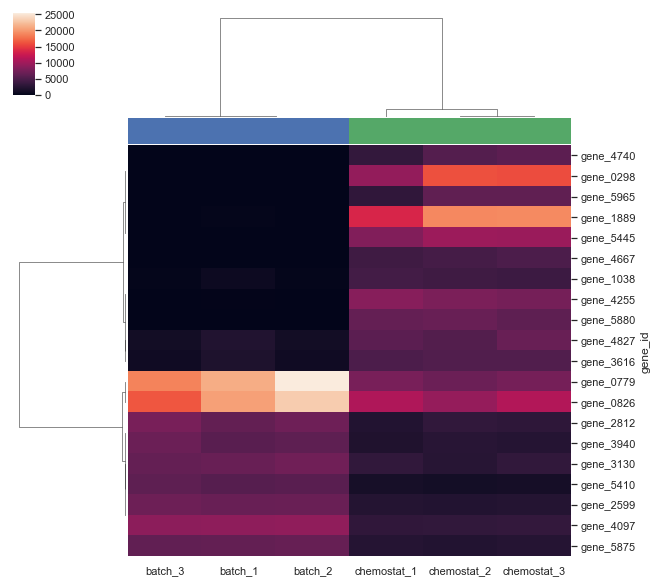

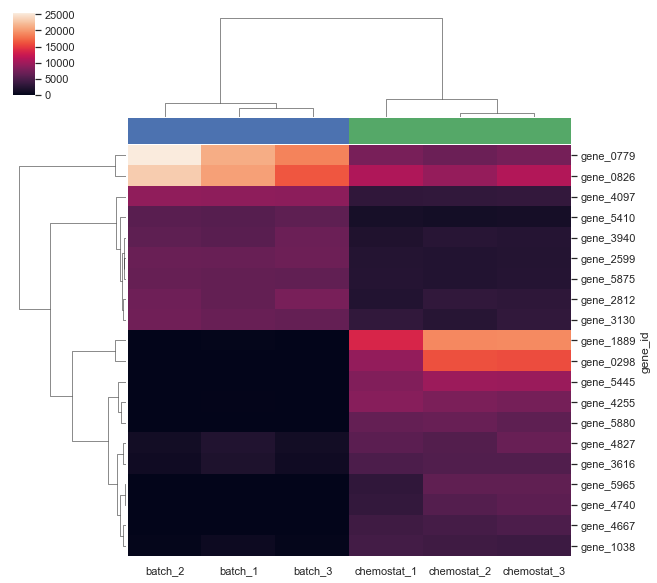

In [39]:
# サンプル間の距離計算手法、クラスター間の距離計算手法による違い
sns.clustermap(top20_df, method='average', metric='correlation', col_colors=colors)
sns.clustermap(top20_df, method='ward', metric='euclidean', col_colors=colors)

## 2.2 K-means & K-medoids （クラスタ「中心」との距離に基づくクラスタリング）

### K-means clustering

In [40]:
import sklearn.cluster
model = sklearn.cluster.KMeans(n_clusters=2)
y = model.fit_predict(df.transpose().values)
print(y)

[1 1 1 0 0 0]


n_clusters: 2  Average silhouette score = 0.8081859603313926


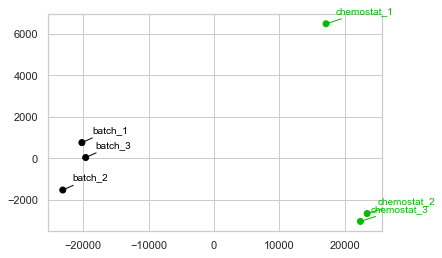

n_clusters: 3  Average silhouette score = 0.6360380259038124


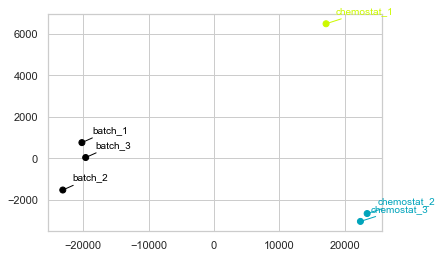

n_clusters: 4  Average silhouette score = 0.314620203586913


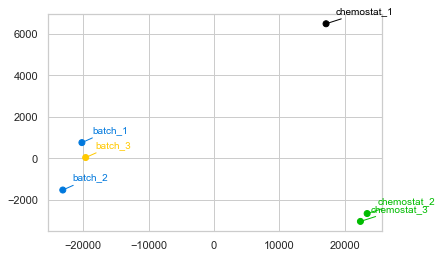

In [41]:
# silhouette解析による適切なクラスター数の推定
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm

X = df.transpose().values
pca = sklearn.decomposition.PCA()
pca_coords = pca.fit_transform(X)

for n_clusters in [2, 3, 4]:
    model = sklearn.cluster.KMeans(n_clusters=n_clusters)
    y = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, y)
    print('n_clusters:',n_clusters,' Average silhouette score =',silhouette_avg)
    cluster_colors = cm.nipy_spectral(y.astype(float) / n_clusters)
    scatter_plot(pca_coords, std_df.columns, cluster_colors)

n_clusters: 2  Average silhouette score = 0.7049787496083262


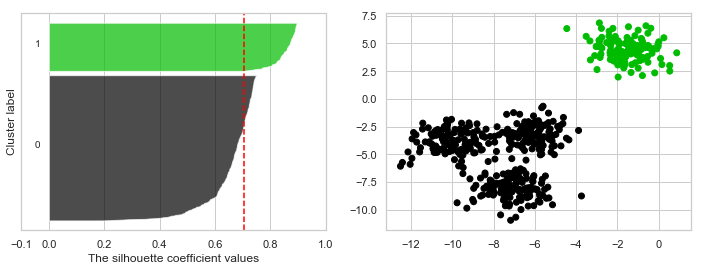

n_clusters: 3  Average silhouette score = 0.5882004012129721


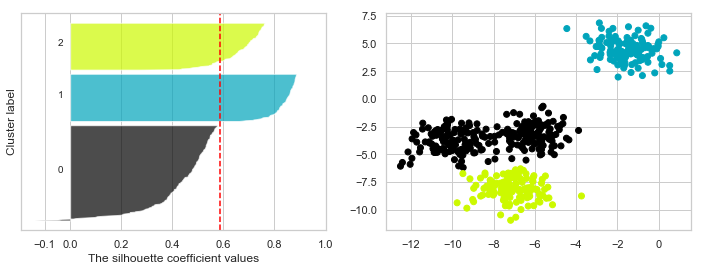

n_clusters: 4  Average silhouette score = 0.6505186632729437


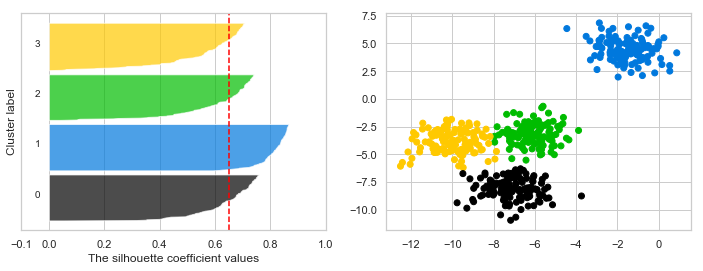

In [42]:
# もっとサンプル数がたくさんある場合は、サンプルごとのシルエットスコアの分布を比較できる
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, center_box=(-10.0, 10.0), shuffle=True, random_state=1)

def plot_silhouette(n_clusters):
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    model = sklearn.cluster.KMeans(n_clusters=n_clusters)
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('n_clusters:',n_clusters,' Average silhouette score =',silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = np.sort(sample_silhouette_values[cluster_labels == i])
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cluster_colors = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=cluster_colors, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    cluster_colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], c=cluster_colors)
    plt.show()

for n_clusters in [2, 3, 4]:
    plot_silhouette(n_clusters)

### K-medoids clustering

平均（mean）ではなくmedoid（すべてのデータ点との距離の和が最小になるデータ点）を使う点だけがK-meansと異なる。

実データの平均を計算する必要がないため、実データを入力する必要がなく、距離行列があればいい

→ ユークリッド距離である必要はなく、任意の距離関数を使える。

In [43]:
# K-medoids clusteringをscikit-learnの使用感っぽく使えるように実装した。
# エラーハンドリングとか全然してないので注意。また、初期値依存性も高い。sklearnのKMeansメソッドは初期化を工夫している。
# 参考：https://www.researchgate.net/publication/272351873_NumPy_SciPy_Recipes_for_Data_Science_k-Medoids_Clustering

import numpy as np
from scipy.spatial.distance import pdist, squareform

class KMedoids():
    """K-Medoids clustering
    
    Parameters
    ----------
    n_clusters : int, optional, default: 2
        Number of clusters to form.
    max_iter : int, optional, default: 100
        Maximum number of iterations of the k-medoids algorithm.
    verbose : boolean, optional, default: False
        Verbosity mode.
    random_state : int, RandomState instance or None, optional, default: None
    dissimilarity : 'euclidean' | 'precomputed', optional, default: 'euclidean'
        Dissimilarity measure to use:
            - 'euclidean':
                Pairwise Euclidean distances between points in the dataset.
            - 'precomputed':
                Pre-computed dissimilarities are passed.
    
    Attributes
    ----------
    cluster_medoids_ : array, [n_clusters]
        Indices of cluster medoids
    labels_ :
        Labels of each point
    """
    def __init__(self, n_clusters=2, max_iter=100, verbose=False,
                random_state=None, dissimilarity='euclidean'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.verbose = verbose
        self.random_state = random_state
        self.dissimilarity = dissimilarity
    
    def _init_medoids(self, X, n_clusters, random_state):
        n_samples = X.shape[0]
        init_indices = random_state.choice(n_samples, n_clusters, replace=False)
        return np.sort(init_indices)
    
    def _k_medoids(self, X, n_clusters, max_iter, random_state, verbose):
        # 初期medoidsをランダムにn_clusters個選択。
        medoids = self._init_medoids(X, n_clusters, random_state)
        if self.verbose:
            print('initial medoids =', medoids)
        new_medoids = np.copy(medoids)
        # ループ開始。medoidsが収束するまで繰り返す。
        for i in range(max_iter):
            # 各サンプルをもっとも近いmedoidsに割り当てる。
            assigned_cluster_labels = np.argmin(X[:, medoids], axis=1)
            for c in range(n_clusters): # クラスタごとに新たなmedoidsを選択。
                # クラスタc に割り当てられたサンプルのインデックスを取得。
                sample_indices_in_c = np.where(assigned_cluster_labels == c)[0]
                # クラスタc に割り当てられたサンプル内の距離行列を抽出。
                distance_matrix_of_c = X[np.ix_(sample_indices_in_c, sample_indices_in_c)]
                # クラスタc 内の各サンプルについて、同一クラスタ内サンプルとの平均距離を計算
                average_distance_in_c = np.mean(distance_matrix_of_c, axis=1)
                # 新たなmedoidは平均距離がもっとも小さいサンプル。
                new_medoid_index_in_c = np.argmin(average_distance_in_c)
                new_medoid_index = sample_indices_in_c[new_medoid_index_in_c]
                new_medoids[c] = new_medoid_index
            np.sort(new_medoids)
            if self.verbose:
                print('\titeration:',i,'\n\t\tnew medoids=',new_medoids)
            if np.array_equal(new_medoids, medoids):
                # medoidsのインデックスが更新されなかったらループ終了。
                break
            medoids = np.copy(new_medoids)
        assigned_cluster_labels = np.argmin(X[:, medoids], axis=1)
        return medoids, assigned_cluster_labels
    
    def fit(self, X):
        """Compute k-medoids clustering.
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity == 'precomputed'``, the input should
            be the dissimilarity matrix.
        """
        if self.dissimilarity == 'precomputed':
            self.dissimilarity_matrix_ = X
        elif self.dissimilarity == 'euclidean':
            self.dissimilarity_matrix_ = squareform(pdist(X))
        else:
            raise ValueError("dissimilarity must be 'precomputed' or 'euclidean'.")
        if self.random_state is None or self.random_state is np.random:
            self.random_state = np.random.mtrand._rand
        elif isinstance(self.random_state, int):
            self.random_state = np.random.RandomState(self.random_state)
        elif isinstance(self.random_state, np.random.RandomState):
            self.random_state = np.random.RandomState
        else:
            raise ValueError("%r cannot be used to seed a numpy.random.RandomState" % self.random_state)
        self.cluster_medoids_, self.labels_ = \
            self._k_medoids(self.dissimilarity_matrix_, self.n_clusters, self.max_iter, self.random_state, self.verbose)
        return self
    
    def fit_predict(self, X):
        """Compute k-medoids clustering and predict cluster index for each sample.
        """
        return self.fit(X).labels_

In [44]:
# K-medoidsクラスタリングの実行
distance_matrix = squareform(pdist(df.transpose().values, metric='correlation')) # 相関係数距離行列
n_clusters = 2

model = KMedoids(n_clusters=n_clusters, dissimilarity='precomputed', verbose=True)
model.fit(distance_matrix)
medoids = model.cluster_medoids_
labels = model.labels_
print('\nMedoids :',df.columns[medoids].values)
print('Clusters :')
for cluster in range(n_clusters):
    print('\tcluster-',cluster,': ',df.columns[labels == cluster].values)

initial medoids = [4 5]
	iteration: 0 
		new medoids= [4 0]
	iteration: 1 
		new medoids= [5 0]
	iteration: 2 
		new medoids= [5 0]

Medoids : ['chemostat_3' 'batch_1']
Clusters :
	cluster- 0 :  ['chemostat_1' 'chemostat_2' 'chemostat_3']
	cluster- 1 :  ['batch_1' 'batch_2' 'batch_3']


## 2.3 混合正規分布 （確率分布に基づくクラスタリング）

実データが、なんからの確率分布がいくつか混ざった混合確率分布から生成されたものであると仮定する手法。

微生物群集構造データではここ数年、Dirichlet Multinomial Mixture がよく使われている。

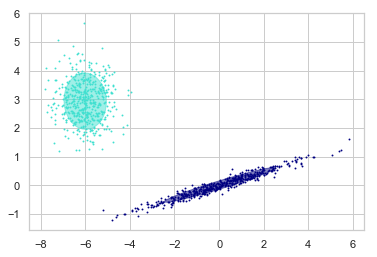

In [45]:
import sklearn.mixture
import matplotlib as mpl

n_samples = 500
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

gmm = sklearn.mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X)

plt.figure()
ax = plt.subplot(111)
Y_ = gmm.predict(X)
cluster_colors = ['navy', 'turquoise']
for i, (mean, cov, color) in enumerate(zip(gmm.means_, gmm.covariances_, cluster_colors)):
    v, w = np.linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(.5)
    ax.add_artist(ell)

Cluster- 0  weight = 9.990121948553962e-05
Cluster- 1  weight = 9.990121948553962e-05
Cluster- 2  weight = 9.990121948553962e-05
Cluster- 3  weight = 0.4996003107356371
Cluster- 4  weight = 9.990121948553962e-05
Cluster- 5  weight = 9.990121948553962e-05
Cluster- 6  weight = 9.990121960282935e-05
Cluster- 7  weight = 9.990121948553962e-05
Cluster- 8  weight = 9.990121948553962e-05
Cluster- 9  weight = 0.4996004795083613


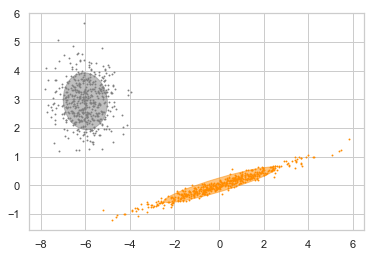

In [57]:
import itertools
cluster_colors = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange', 'gray'])

#  n_compoments=10 とすることで、実際の構造よりかなり大きな10個ぶんのクラスタを仮定して推論をはじめていることに注意
# 最終的には、2つ以外のクラスタが推論の過程で勝手につぶれてくれる
vbgmm = sklearn.mixture.BayesianGaussianMixture(n_components=10, max_iter=300,
                                                covariance_type='full', weight_concentration_prior_type='dirichlet_distribution')
vbgmm.fit(X)

for i, cluster_weight in enumerate(vbgmm.weights_):
    print('Cluster-', i, ' weight =', cluster_weight)

plt.figure()
ax = plt.subplot(111)
Y_ = vbgmm.predict(X)
for i, (mean, cov, color) in enumerate(zip(vbgmm.means_, vbgmm.covariances_, cluster_colors)):
    v, w = np.linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(.5)
    ax.add_artist(ell)

Number of clusters estimated: 1
	cluster- 0  weights = 1.0


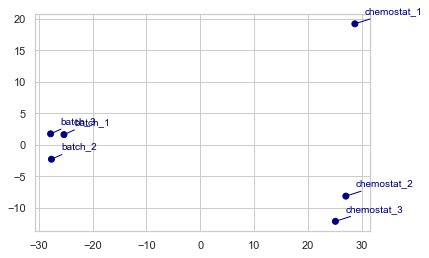

Number of clusters estimated: 2
	cluster- 0  weights = 0.5
	cluster- 1  weights = 0.5


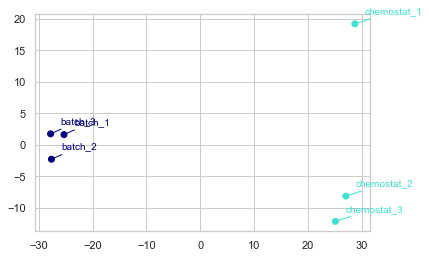

Number of clusters estimated: 3
	cluster- 0  weights = 0.47619047619047605
	cluster- 1  weights = 0.19047619047619058
	cluster- 2  weights = 0.3333333333333333


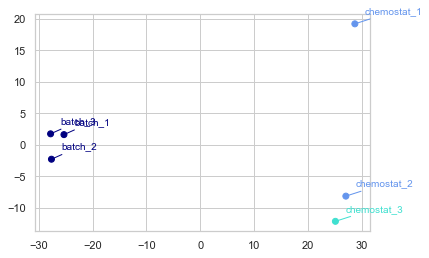

Number of clusters estimated: 4
	cluster- 0  weights = 0.32142857142857134
	cluster- 1  weights = 0.32142857142857134
	cluster- 2  weights = 0.17857142857142866
	cluster- 3  weights = 0.17857142857142866


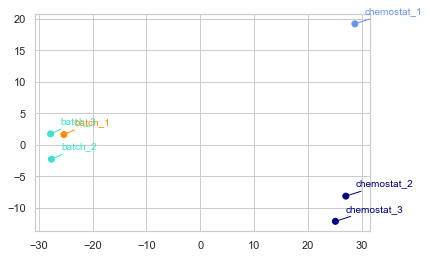

In [58]:
# サンプル間で分散の大きいトップ1000の遺伝子のみを使って推定
var1000_genes = std_df.var(axis=1).sort_values(ascending=False).index[:1000]
X = std_df.loc[var1000_genes, :].transpose().values

pca = sklearn.decomposition.PCA()
pca_coords = pca.fit_transform(X)
cluster_colors = np.array(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])

for n_clusters in [1, 2, 3, 4]:
    vbgmm = sklearn.mixture.BayesianGaussianMixture(n_components=n_clusters,
                                                    weight_concentration_prior_type='dirichlet_distribution')
    vbgmm.fit(X)
    print('Number of clusters estimated:', n_clusters)
    for c in range(n_clusters):
        print('\tcluster-', c, ' weights =', vbgmm.weights_[c])
    y = vbgmm.predict(X)
    scatter_plot(pca_coords, std_df.columns, cluster_colors[y])